# Modeling Game

To do:
1. Create a function that automatically sets the values of parameters based on their types.
1. Plot mRNA7 in the new simulation after parameter fitting, or at least its residuals.

In [1]:
%matplotlib inline
import numpy as np
import model_fitting as mf
import tellurium as te
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
import lmfit
import os
import re

In [2]:
# Symbols
# Column names
TIME = 'time'

TIME_TO_POINT = 10 # 1 point for every second

In [3]:
# Initial model
model_1 = '''
// Created by libAntimony v3.9.4
model *pathway()

  // Compartments and Species:
  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;
  species mRNA6, P7, mRNA7, P8, mRNA8;

  // Reactions:
  J1:  => mRNA1; L1 + Vm1*((K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)/(1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)) - d_mRNA1*mRNA1;
  F1:  => P1; a_protein1*mRNA1 - d_protein1*P1;
  J2:  => mRNA2; L2 + Vm2*(K1_2*P4^H2/(1 + K1_2*P4^H2)) - d_mRNA2*mRNA2;
  F2:  => P2; a_protein2*mRNA2 - d_protein2*P2;
  J3:  => mRNA3; L3 + Vm3*(K1_3*P6^H3/(1 + K1_3*P6^H3)) - d_mRNA3*mRNA3;
  F3:  => P3; a_protein3*mRNA3 - d_protein3*P3;
  J4:  => mRNA4; L4 + Vm4*(1/(1 + K1_4*P2^H4)) - d_mRNA4*mRNA4;
  F4:  => P4; a_protein4*mRNA4 - d_protein4*P4;
  J5:  => mRNA5; L5 - d_mRNA5*mRNA5;
  F5:  => P5; a_protein5*mRNA5 - d_protein5*P5;
  J6:  => mRNA6; L6 + Vm6*(K1_6*P7^H6/(1 + K1_6*P7^H6 + K2_6*P1^H6 + K1_6*K2_6*P7^H6*P1^H6)) - d_mRNA6*mRNA6;
  F6:  => P6; a_protein6*mRNA6 - d_protein6*P6;
  J7:  => mRNA7; L7 - d_mRNA7*mRNA7;
  F7:  => P7; a_protein7*mRNA7 - d_protein7*P7;
  J8:  => mRNA8; L8 + Vm8*(1/(1 + K1_8*P1^H8)) - d_mRNA8*mRNA8;
  F8:  => P8; a_protein8*mRNA8 - d_protein8*P8;
  '''

In [4]:
# Initial constants

model_2 = '''

 // Species initializations:
  INPUT = 1;
  P1 = 0;
  mRNA1 = 0;
  P2 = 0;
  mRNA2 = 0;
  P3 = 0;
  mRNA3 = 0;
  P4 = 0;
  mRNA4 = 0;
  P5 = 0;
  mRNA5 = 0;
  P6 = 0;
  mRNA6 = 0;
  P7 = 0;
  mRNA7 = 0;
  P8 = 0;
  mRNA8 = 0;

  // Variable initializations:
  d_protein1 = 0.01576525;
  d_mRNA1 = 0.600013;
  L1 = 0.0284569399501349;
  Vm1 = 1.16380673480284;
  a_protein1 = 0.089105566248939;
  H1 = 4.52340391321994;
  K1_1 = 0.0269204907071558;
  K2_1 = 0.0169635567504703;
  K3_1 = 0.0114278645720656;
  d_protein2 = 0.0100753359178861;
  d_mRNA2 = 0.607263145327485;
  L2 = 0.01126375;
  Vm2 = 0.855433454948057;
  a_protein2 = 0.0825104648147814;
  H2 = 3.21939257313515;
  K1_2 = 0.0170170903653747;
  d_protein3 = 0.0165270958726424;
  d_mRNA3 = 1.4096553751623;
  L3 = 0.0108824170117358;
  Vm3 = 1.61383118795785;
  a_protein3 = 0.118672807163739;
  H3 = 4.57189341195625;
  K1_3 = 0.0133069236136431;
  d_protein4 = 0.0205716618573404;
  d_mRNA4 = 1.19069657063437;
  L4 = 0.0142166568749038;
  Vm4 = 0.916251896011744;
  a_protein4 = 0.0862964088164644;
  H4 = 5.00512303222327;
  K1_4 = 0.0179894288457716;
  d_protein5 = 0.0180685727313577;
  d_mRNA5 = 0.911653907722886;
  L5 = 0.0124824037745626;
  a_protein5 = 0.106293056264931;
  d_protein6 = 0.0178004316181647;
  d_mRNA6 = 0.67287496171115;
  L6 = 0.0166516087433626;
  Vm6 = 0.889302076744445;
  a_protein6 = 0.0890528700251159;
  H6 = 5.58112408673455;
  K1_6 = 0.0139445776013774;
  K2_6 = 0.0121764364668572;
  d_protein7 = 0.0206180615545929;
  d_mRNA7 = 0.618711430584466;
  L7 = 0.0178636133026099;
  a_protein7 = 0.0764169841455256;
  d_protein8 = 0.0131749080364666;
  d_mRNA8 = 1.17483328491068;
  L8 = 0.0165535374304033;
  Vm8 = 0.87881445337468;
  a_protein8 = 0.103749989801903;
  H8 = 2.17775388441324;
  K1_8 = 0.0168599518440462;

  // Other declarations:
  const d_protein1, d_mRNA1, L1, Vm1, a_protein1, H1, K1_1, K2_1, K3_1, d_protein2;
  const d_mRNA2, L2, Vm2, a_protein2, H2, K1_2, d_protein3, d_mRNA3;
  const L3, Vm3, a_protein3, H3, K1_3, d_protein4, d_mRNA4, L4;
  const Vm4, a_protein4, H4, K1_4, d_protein5, d_mRNA5, L5;
  const a_protein5, d_protein6, d_mRNA6, L6, Vm6, a_protein6;
  const H6, K1_6, K2_6, d_protein7, d_mRNA7, L7, a_protein7;
  const d_protein8, d_mRNA8, L8, Vm8, a_protein8, H8, K1_8;
end
'''

In [5]:
# Modified model
model_1 = '''
// Created by libAntimony v3.9.4
model *pathway()

  // Compartments and Species:
  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;
  species mRNA6, P7, mRNA7, P8, mRNA8;

  // Reactions:
  J1:  => mRNA1; L1 + Vm1*((K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)/(1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)) - d_mRNA1*mRNA1;
  F1:  => P1; a_protein1*mRNA1 - d_protein1*P1;
  J2:  => mRNA2; L2 + Vm2*(K1_2*P4^H2/(1 + K1_2*P4^H2)) - d_mRNA2*mRNA2;
  F2:  => P2; a_protein2*mRNA2 - d_protein2*P2;
  J3:  => mRNA3; L3 + Vm3*(K1_3*P6^H3/(1 + K1_3*P6^H3)) - d_mRNA3*mRNA3;
  F3:  => P3; a_protein3*mRNA3 - d_protein3*P3;
  J4:  => mRNA4; L4 + Vm4*(1/(1 + K1_4*P2^H4)) - d_mRNA4*mRNA4;
  F4:  => P4; a_protein4*mRNA4 - d_protein4*P4;
  J5:  => mRNA5; L5 - d_mRNA5*mRNA5;
  F5:  => P5; a_protein5*mRNA5 - d_protein5*P5;
  J6:  => mRNA6; L6 + Vm6*(K1_6*P7^H6/(1 + K1_6*P7^H6 + K2_6*P1^H6 + K1_6*K2_6*P7^H6*P1^H6)) - d_mRNA6*mRNA6;
  F6:  => P6; a_protein6*mRNA6 - d_protein6*P6;
  J7:  => mRNA7; L7 + Vm7*(K1_7*P1^H7/(1 + K1_7*P1^H7)) - d_mRNA7*mRNA7;  # added term for P1
  F7:  => P7; a_protein7*mRNA7 - d_protein7*P7;
  J8:  => mRNA8; L8 + Vm8*(1/(1 + K1_8*P1^H8)) - d_mRNA8*mRNA8;
  F8:  => P8; a_protein8*mRNA8 - d_protein8*P8;
  '''

In [6]:
# Constants

model_2 = '''

 // Constants to estimate
 Vm7 = 0;
 K1_7 = 0;
 H7 = 0;

 // Species initializations:
  INPUT = 1;
  P1 = 0;
  mRNA1 = 0;
  P2 = 0;
  mRNA2 = 0;
  P3 = 0;
  mRNA3 = 0;
  P4 = 0;
  mRNA4 = 0;
  P5 = 0;
  mRNA5 = 0;
  P6 = 0;
  mRNA6 = 0;
  P7 = 0;
  mRNA7 = 0;
  P8 = 0;
  mRNA8 = 0;

  // Variable initializations:
  d_protein1 = 0.01576525;
  d_mRNA1 = 0.600013;
  L1 = 0.0284569399501349;
  Vm1 = 1.16380673480284;
  a_protein1 = 0.089105566248939;
  H1 = 4.52340391321994;
  K1_1 = 0.0269204907071558;
  K2_1 = 0.0169635567504703;
  K3_1 = 0.0114278645720656;
  d_protein2 = 0.0100753359178861;
  d_mRNA2 = 0.607263145327485;
  
  L2 = 0.01126375;
  Vm2 = 0.855433454948057;
  a_protein2 = 0.0825104648147814;
  H2 = 3.21939257313515;
  K1_2 = 0.0170170903653747;
  
  d_protein3 = 0.0165270958726424;
  d_mRNA3 = 1.4096553751623;
  L3 = 0.0108824170117358;
  Vm3 = 1.61383118795785;
  a_protein3 = 0.118672807163739;
  H3 = 4.57189341195625;
  K1_3 = 0.0133069236136431;
  
  d_protein4 = 0.0205716618573404;
  d_mRNA4 = 1.19069657063437;
  L4 = 0.0142166568749038;
  Vm4 = 0.916251896011744;
  a_protein4 = 0.0862964088164644;
  H4 = 5.00512303222327;
  K1_4 = 0.0179894288457716;
  
  d_protein5 = 0.0180685727313577;
  d_mRNA5 = 0.911653907722886;
  L5 = 0.0124824037745626;
  a_protein5 = 0.106293056264931;
  d_protein6 = 0.0178004316181647;
  
  d_mRNA6 = 0.67287496171115;
  L6 = 0.0166516087433626;
  Vm6 = 0.889302076744445;
  a_protein6 = 0.0890528700251159;
  H6 = 5.58112408673455;
  K1_6 = 0.0139445776013774;
  K2_6 = 0.0121764364668572;
  
  d_protein7 = 0.0206180615545929;
  d_mRNA7 = 0.618711430584466;
  L7 = 0.0178636133026099;
  a_protein7 = 0.0764169841455256;
  
  d_protein8 = 0.0131749080364666;
  d_mRNA8 = 1.17483328491068;
  L8 = 0.0165535374304033;
  Vm8 = 0.87881445337468;
  a_protein8 = 0.103749989801903;
  H8 = 2.17775388441324;
  K1_8 = 0.0168599518440462;

  // Other declarations:
  const d_protein1, d_mRNA1, L1, Vm1, a_protein1, H1, K1_1, K2_1, K3_1, d_protein2;
  const d_mRNA2, L2, Vm2, a_protein2, H2, K1_2, d_protein3, d_mRNA3;
  const L3, Vm3, a_protein3, H3, K1_3, d_protein4, d_mRNA4, L4;
  const Vm4, a_protein4, H4, K1_4, d_protein5, d_mRNA5, L5;
  const a_protein5, d_protein6, d_mRNA6, L6, Vm6, a_protein6;
  const H6, K1_6, K2_6, d_protein7, d_mRNA7, L7, a_protein7;
  const d_protein8, d_mRNA8, L8, Vm8, a_protein8, H8, K1_8;
end
'''

In [7]:
model = model_1 + model_2
  
rr = te.loada(model)

In [8]:
def simulate(model, is_mrna=True, is_protein=True, is_input=False):
    rr = te.loada(model)
    data = rr.simulate(0, 1200, 120)
    length = np.shape(data)[0]
    df_data = pd.DataFrame(data)
    columns = [s[1:-1] for s in data.colnames]
    columns[0] = TIME
    times = [10*v for v in range(length)]
    df_data.columns = columns
    df_data[TIME] = times
    df_data = df_data.set_index(TIME)
    #
    def delColumn(string):
        for col in df_data.columns:
            if col[:len(string)] == string:
                del df_data[col]
    #
    if not is_mrna:
        delColumn("mRNA")
    if not is_protein:
        delColumn("P")
    if not is_input:
        delColumn("INPUT")
    return df_data

In [9]:
def getRNASeq(csv_file):
    path = os.path.join("data", csv_file)
    df = pd.read_csv(path)
    df[TIME] = [int(v) for v in df[TIME]]
    df = df.set_index(TIME)
    return df

In [10]:
def makeResiduals(model, df):
    """
    Calculates the residuals for the columns in common.
    """
    df_sim = simulate(model)
    columns = set(df_sim.columns).intersection(df.columns)
    return df[columns] - df_sim[columns]

In [21]:
def plotData(df_data, starttime=0, endtime=1200):
    last = int(endtime/TIME_TO_POINT)
    indices = list(range(last))
    plt.plot(df_data.index[0:last], df_data.loc[df_data.index[indices],:])
    plt.xlabel("Time")
    plt.legend(df_data.columns, loc="upper right")

In [13]:
def makeParameters(constants):
    """
    Creates parameters with the correct ranges based on their names.
    :param str constants: names of constant
    """
    if isinstance(constants, str):
        constants = [constants]
    # mins and maxs for parameters by their initial string (up to a number)
    ranges_dict = {"Vm": (0.5, 2), "K": (0.01, 0.03), "H": (2, 8), 
                   "d_protein": (0.01, 0.03), "d_mRNA": (0.5, 2) }
    parameters = lmfit.Parameters()
    for constant in constants:
        pfxs = re.findall(r"^\D+", constant)
        if len(pfxs) != 1:
            raise ValueError("Cannot find match for %s" % constant)
        pfx = pfxs[0]
        min_val, max_val = ranges_dict[pfx]
        initial_val = (min_val + max_val) / 2
        parameters.add(constant, value=initial_val, min=min_val, max=max_val)
    return parameters

In [14]:
df_rnaseq = getRNASeq("Curie_Wild_0_RNASeqResult_Clean.csv")
df_res = makeResiduals(model, df_rnaseq)

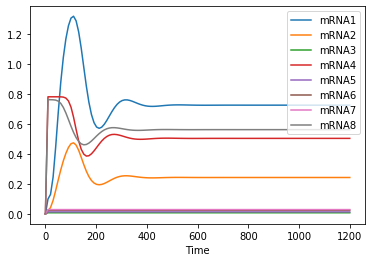

In [22]:
df_base_model = mf.matrixToDF(mf.runSimulation(model=model, sim_time=1200, num_points=120))
columns = ["mRNA%d" % v for v in range(1,9)]
plotData(df_base_model[columns])

In [ ]:
plotData(df_res, endtime=300)

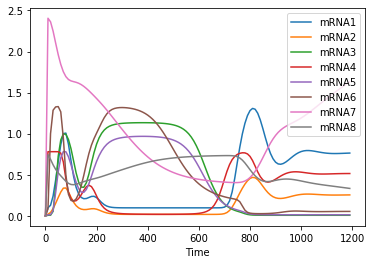

In [23]:
plotData(df_rnaseq, endtime=1200)

Observations
1. mRNA1, mRNA7, mRNA8 all rise rapidly. Suggests that mRNA7 has inputs from P1 as does mRNA8.

In [ ]:
STOP

In [ ]:
# Cross validate to evaluate the new model
constants = ['Vm7', 'K1_7', 'H7']
parameters = makeParameters(constants)
columns = ["mRNA%d" % n for n in range(1, 8)]
sim_time = 100
num_points = int(sim_time/10)
df_obs = df_rnaseq.loc[df_rnaseq.index[range(num_points)], :]
df_obs = pd.DataFrame(df_obs['mRNA7'])  # Focus on the one we're trying to fix
list_parameters, rsqs = mf.crossValidate(df_obs, model=model, parameters=parameters,
                                         num_points=num_points, 
                                         method='leastsqs',
                                         sim_time=sim_time,
                                         num_folds=2)

In [ ]:
rsqs

Thoughts
1. Verify that data are aligned between obs and sim

In [ ]:
df_rnaseq

In [ ]:
data = rr.simulate(0, 1200, 120)

In [ ]:
df_data = pd.DataFrame(data)

In [ ]:
data.colnames